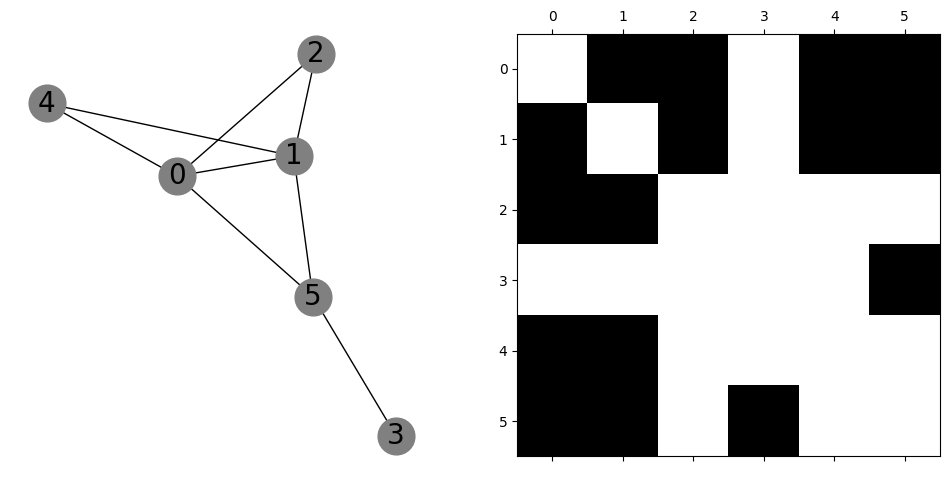

In [ ]:
# HPC Class: Graph Partitioning - An Overview
# Author: Aryan Eftekhari
# Email: aryan.eftkehari@gmail.com

# INFO:
# Generate ranodm graph

# TODO:
# Nothing to play around with

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Creating a simple undirected graph with 5 nodes
#G = nx.star_graph(6)
G = random_graph = nx.gnp_random_graph(6, 0.5)

# Drawing the graph
plt.figure(figsize=(12, 6))

# Plot 1: The Graph
plt.subplot(121)
nx.draw(G, with_labels=True, node_color='gray', node_size=700, font_size=20)

# Plot 2: The Adjacency Matrix
plt.subplot(122)
matrix = nx.adjacency_matrix(G).todense()
plt.spy(matrix)

# Showing the plots
plt.show()


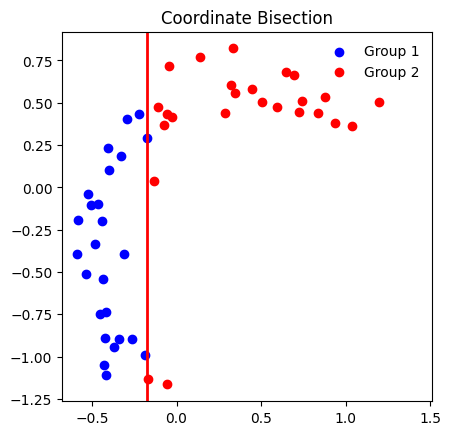

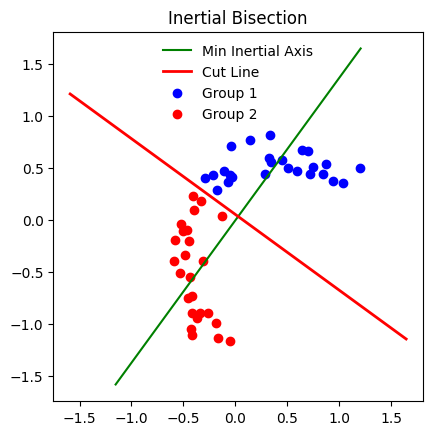

In [ ]:
# HPC Class: Graph Partitioning - An Overview
# Author: Aryan Eftekhari
# Email: aryan.eftkehari@gmail.com

# INFO:
# Coord and Inertial Bisection

# TODO:
# Nothing to play around with

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from scipy.stats import stats

def coordinate_bisection(points):
    """
    Coordinate Bisection based on the median of the specified axis.
    """
    median_value = np.median(points[:, 0])
    group1 = points[points[:, 0] < median_value]
    group2 = points[points[:, 0] > median_value]
    return group1, group2, median_value

def inertial_bisection(points):
    """
    Inertial Bisection based on the median after aligning with the largest eigenvector.
    """
    # Compute the covariance matrix of the points
    covariance_matrix = np.cov(points.T)

    # Eigen decomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Find the largest eigenvector (principal direction)
    largest_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]

    # Project the points onto the largest eigenvector
    projected_values = points @ largest_eigenvector  # 1D projections along the eigenvector

    # Find the median of the projections
    median_projected = np.median(projected_values)

    # Determine the cut line
    point_on_line = median_projected * largest_eigenvector  # A point on the cut line

    # Split points based on the median
    group1 = points[projected_values < median_projected]
    group2 = points[projected_values >= median_projected]  # Include equality for balance

    # Return the two groups and the cut line
    return group1, group2, (largest_eigenvector, point_on_line)

# Generate half moon scatter data
X, y = make_moons(n_samples=100, noise=0.1, random_state=0)
X_one_lobe = X[y == 0]

# Rotate the data
theta = np.radians(50)
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
X_one_lobe_rotated = X_one_lobe @ rotation_matrix.T

# Centering the data
X = X_one_lobe_rotated - X_one_lobe_rotated.mean(axis=0)

###############################
# Coordinate bisection
###############################
group1, group2, cut = coordinate_bisection(X)

# Visualization for coordinate bisection
plt.figure()
plt.axvline(x=cut,color='red',linewidth=2)
plt.scatter(group1[:, 0], group1[:, 1], color='blue', label='Group 1')
plt.scatter(group2[:, 0], group2[:, 1], color='red', label='Group 2')
plt.legend(frameon=False)
plt.axis('square')   # force the axes box to be square
plt.title('Coordinate Bisection')
plt.show()

###############################
# Inertial bisection
###############################
group1, group2, (direction, point_on_line) = inertial_bisection(X)

reg_line_start = point_on_line - 2 * direction
reg_line_end =   point_on_line + 2 * direction
cut_line_start = point_on_line - 2 * np.array([-direction[1], direction[0]])  # Orth. to the reg_line
cut_line_end =   point_on_line + 2 * np.array([-direction[1], direction[0]])  # Orth. to the reg_line

# Visualization for inertial bisection
plt.figure()
plt.plot([reg_line_start[0], reg_line_end[0]], [reg_line_start[1], reg_line_end[1]], color="green", label="Min Inertial Axis")
plt.plot([cut_line_start[0], cut_line_end[0]], [cut_line_start[1], cut_line_end[1]], color="red", label="Cut Line",linewidth=2)
plt.scatter(group1[:, 0], group1[:, 1], color='blue', label='Group 1')
plt.scatter(group2[:, 0], group2[:, 1], color='red', label='Group 2')
plt.legend(frameon=False)
plt.axis('square')   # force the axes box to be square
plt.title('Inertial Bisection')
plt.show()


In [ ]:
# HPC Class: Graph Partitioning - An Overview
# Author: Aryan Eftekhari
# Email: aryan.eftkehari@gmail.com

# INFO:
# Using spectral partitioning to improve Sparse Matrix-Vector operation

# TODO:
# Nothing to play around with

import numpy as np
from scipy.linalg import block_diag
from sklearn.cluster import SpectralClustering
import scipy as sp
import matplotlib.pyplot as plt

def create_block_diagonal_matrix(block_size1, block_size2, total_size):
    """
    Create a block diagonal matrix with specified block sizes.
    """
    assert block_size1 + block_size2 == total_size, "Sum of block sizes must equal total size"
    block1 = np.ones((block_size1, block_size1))
    block2 = np.ones((block_size2, block_size2))
    matrix = block_diag(block1, block2)

    # Introduce non-diagonal elements
    matrix[-1, 0] = 1
    matrix[0, -1] = 1

    return matrix

def random_permutation(matrix):
    """
    Apply a random permutation to the matrix.
    """
    perm = np.random.permutation(matrix.shape[0])
    permuted_matrix = matrix[perm, :][:, perm]
    return permuted_matrix

def spectral_partitioning(matrix, n_clusters=2):
    """
    Apply spectral partitioning to the matrix.
    """
    temp = matrix - np.diag(np.diag(matrix))
    L = np.diag(np.sum(temp, axis=1)) - temp
    eigenvalues, eigenvectors = sp.linalg.eigh(L)
    fiedler_vector = eigenvectors[:, 1]
    labels = (fiedler_vector > 0).astype(int)
    return labels

def recover_original_structure(matrix, labels):
    """
    Recover the original block structure based on the labels.
    """
    sorted_idx = np.argsort(labels)
    recovered_matrix = matrix[sorted_idx, :][:, sorted_idx]
    return recovered_matrix

# Parameters
n = 20  # Total size of the matrix
block_size1 = int(n / 2)  # Size of the first block
block_size2 = n - block_size1  # Size of the second block

# Create a block diagonal matrix
matrix = create_block_diagonal_matrix(block_size1, block_size2, n)

# Randomly permute the matrix
permuted_matrix = random_permutation(matrix)

# Spectral partitioning
labels = spectral_partitioning(permuted_matrix)

# Recover the original block structure
recovered_matrix = recover_original_structure(permuted_matrix, labels)

# Display the matrices
print("Base(Optimal) A=\n", matrix)
print("A=\n", permuted_matrix)
print("PAP'=\n", recovered_matrix)


Base(Optimal) A=
 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.